# Adam Demirli - Technical Assessment Challenge 

## Table of Contents:
* Section 1 - Data Exploration
* Section 2 - Data Preparation and Feature Engineering
* Section 3 - Classification Model (Vehicle Trim)
    - Feature Selection
    - Hyperparmeter Tuning
    - Results (Metrics)
    - Final Model
* Section 4 - Regression Model (Listing Price)
    - Feature Selection
    - Hyperparmeter Tuning
    - Results (Metrics)
    - Final Model
* Section 5 - Predictions Output

In [3]:
import math
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
print("Python version:", platform.python_version())

Python version: 3.7.12


In [5]:
pd.options.display.max_columns = None

# Section 1 - Data Exploration

In [6]:
# Importing training and testing datasets

df_init = pd.read_csv("Training_DataSet.csv")
df_test = pd.read_csv("Test_Dataset.csv")

In [7]:
# Displaying training dataset contents

display(df_init[0:2])
print(f"\nNumber of columns: {len(df_init.columns)}")

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
0,3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,White,Black,4X4,3.6L V6,"['Adaptive Cruise Control', 'Antilock Brakes',...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",8.600069,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
1,3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,Black,NaN,NaN,NaN,NaN,Gasoline,"1 Owner, Buyback Protection Eligible",2.920127,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0



Number of columns: 29


In [8]:
# Noting the cartegorical, numerical, and target columns by index

categ_cols = df_init.columns[
    [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25]
]
num_cols = df_init.columns[[5, 6, 18, 20, 26]]

df_y_categ = df_init[df_init.columns[[27]]]
df_y_num = df_init[df_init.columns[[28]]]

## Numerical Features

Text(0.5, 0.93, 'Box Plots for Numerical Features')

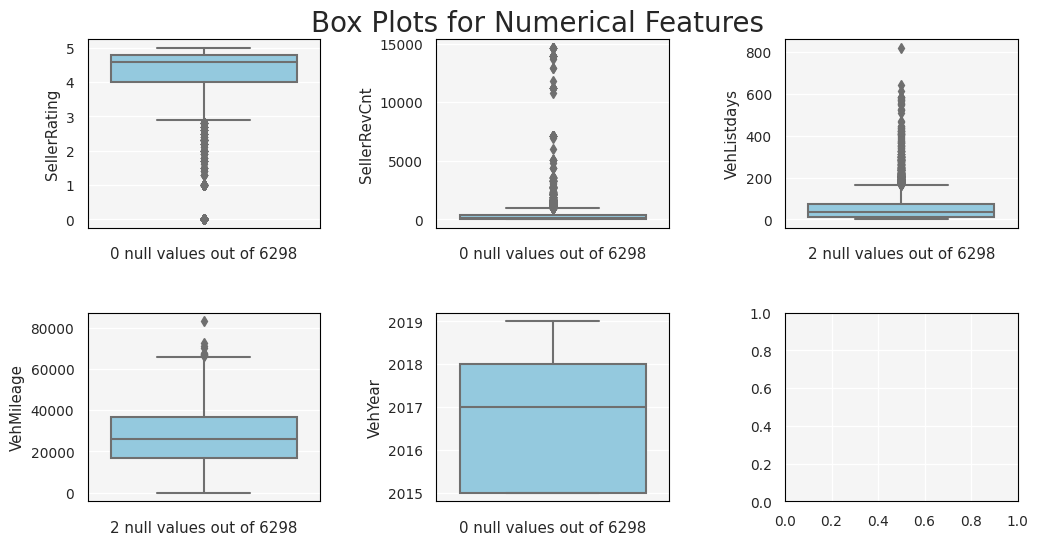

In [9]:
# Generating box plots of all numerical features with number of null values

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.9,
)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for feature, ax in zip(num_cols, axs.ravel()):
    sns.boxplot(y=feature, data=df_init[num_cols], ax=ax, color="skyblue")
    ax.set_xlabel(
        f"{sum(df_init[feature].isnull().values)} null values out of {len(df_init[feature].isnull().values)}"
    )

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.suptitle("Box Plots for Numerical Features", y=0.93, fontsize=20)

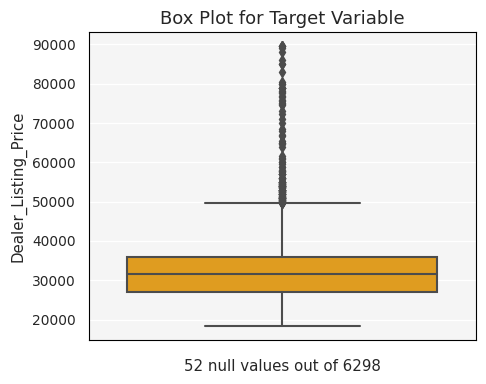

In [10]:
# Generating a box plot for the numerical target feature with number of null values

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.9,
)

plt.figure(figsize=(5, 4))
plt.title("Box Plot for Target Variable", fontsize=13)
plt.xlabel(
    f"{sum(df_y_num.isnull().values)[0]} null values out of {len(df_y_num.isnull().values)}"
)
plt.ylabel("Dealer Listing Price")

sns.boxplot(y="Dealer_Listing_Price", data=df_y_num, color="orange");

## Categorical Features

In [11]:
# Listing all unique categorical target values with their counts
df_y_categ["Vehicle_Trim"].value_counts().to_frame().reset_index().set_axis(
    ["Target Class", "count"], axis="columns"
)

,Target Class,count
0,Limited,1912
1,Premium Luxury,747
2,Laredo,704
3,Luxury,645
4,Overland,381
5,Altitude,325
6,Summit,242
7,Trailhawk,178
8,Base,159
9,Platinum,131


In [12]:
# Checking for null values in the categorical columns
df_init[categ_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ListingID        6298 non-null   int64  
 1   SellerCity       6298 non-null   object 
 2   SellerIsPriv     6298 non-null   bool   
 3   SellerListSrc    6296 non-null   object 
 4   SellerName       6298 non-null   object 
 5   SellerState      6298 non-null   object 
 6   SellerZip        6296 non-null   float64
 7   VehBodystyle     6298 non-null   object 
 8   VehCertified     6298 non-null   bool   
 9   VehColorExt      6225 non-null   object 
 10  VehColorInt      5570 non-null   object 
 11  VehDriveTrain    5897 non-null   object 
 12  VehEngine        5937 non-null   object 
 13  VehFeats         6023 non-null   object 
 14  VehFuel          6296 non-null   object 
 15  VehHistory       6097 non-null   object 
 16  VehMake          6298 non-null   object 
 17  VehModel      

In [13]:
# Listing unique values and their counts, for all categorical columns

df_counts = pd.DataFrame()

for feature in categ_cols:
    df_count = (
        df_init[feature]
        .value_counts()
        .to_frame()
        .reset_index()
        .set_axis([f"{feature}", f"{feature}_count"], axis="columns")
    )
    df_counts = pd.concat([df_counts, df_count], axis=1)

df_counts[0:4]

,ListingID,ListingID_count,SellerCity,SellerCity_count,SellerIsPriv,SellerIsPriv_count,SellerListSrc,SellerListSrc_count,SellerName,SellerName_count,SellerState,SellerState_count,SellerZip,SellerZip_count,VehBodystyle,VehBodystyle_count,VehCertified,VehCertified_count,VehColorExt,VehColorExt_count,VehColorInt,VehColorInt_count,VehDriveTrain,VehDriveTrain_count,VehEngine,VehEngine_count,VehFeats,VehFeats_count,VehFuel,VehFuel_count,VehHistory,VehHistory_count,VehMake,VehMake_count,VehModel,VehModel_count,VehPriceLabel,VehPriceLabel_count,VehSellerNotes,VehSellerNotes_count,VehType,VehType_count,VehTransmission,VehTransmission_count
0,3287,1,Chicago,118.0,False,6284.0,Digital Motorworks (DMi),3086.0,Vroom (Online Dealer - Nationwide Delivery),381.0,IL,753.0,49037.0,101.0,SUV,6298.0,False,4879.0,Bright White Clearcoat,586.0,Black,3018.0,4WD,3836.0,3.6L V6 24V MPFI DOHC,1851.0,"['1st and 2nd row curtain head airbags', '4-wh...",868.0,Gasoline,5902.0,"1 Owner, Buyback Protection Eligible",2919.0,Jeep,4199.0,Grand Cherokee,4199.0,Good Deal,4488.0,CARVANA CERTIFIED INCLUDES: 150-POINT INSPECTI...,218.0,Used,6298.0,8-Speed Automatic,4395.0
1,5780500,1,Battle Creek,103.0,True,14.0,Inventory Command Center,1189.0,Carvana,236.0,OH,566.0,55110.0,40.0,NaN,NaN,True,1419.0,Billet Silver Metallic Clearcoat,386.0,Jet Black,795.0,FWD,1093.0,3.6L V6 24V GDI DOHC,1085.0,"['1st and 2nd row curtain head airbags', '4-wh...",580.0,E85 Flex Fuel,343.0,"1 Owner, Non-Personal Use Reported, Buyback Pr...",1961.0,Cadillac,2099.0,XT5,2099.0,Great Deal,844.0,"With Vroom, you can buy your next car from the...",206.0,NaN,NaN,8-Speed Automatic w/OD,676.0
2,5779657,1,Columbus,63.0,NaN,NaN,HomeNet Automotive,1037.0,Henkel Chrysler Dodge Jeep Ram,100.0,MI,534.0,22182.0,39.0,NaN,NaN,NaN,NaN,Brilliant Black Crystal Pearlcoat,378.0,Shara Beige,263.0,AWD,725.0,Regular Unleaded V-6 3.6 L/220,640.0,"['1st and 2nd row curtain head airbags', '4-wh...",309.0,Diesel,41.0,"1 Owner, Accident(s) Reported, Buyback Protect...",238.0,NaN,NaN,NaN,NaN,Fair Price,681.0,CarMax makes car buying easy and hassle-free. ...,26.0,NaN,NaN,Automatic,523.0
3,5778762,1,Louisville,59.0,NaN,NaN,Jeep Certified Program,709.0,OffLeaseOnly.com The Nation&#x27;s Used Car De...,37.0,WI,431.0,60641.0,35.0,NaN,NaN,NaN,NaN,Black,369.0,Sahara Beige,209.0,4X4,52.0,Gas V6 3.6L/222.6,375.0,"['1st and 2nd row curtain head airbags', '4-wh...",285.0,Unknown,10.0,"1 Owner, Accident(s) Reported, Non-Personal Us...",179.0,NaN,NaN,NaN,NaN,NaN,NaN,"3.6L V6, Black Heated Leather, 4x4, Touchscree...",19.0,NaN,NaN,AUTOMATIC,103.0


# Section 2 - Data Preparation and Feature Engineering


### Helper Functions

In [14]:
# The following functions are used by the data_prep_func() function

encoder = dict()


def ohe_and_trim_sparse(df, is_test_set: bool, col_name: str, trim=None):
    """
    This functions one hot encodes categorical columns.
    Must pass in the column name to encode.
    One hot encoder will fit training data (i.e. is_test_set=False).
    The trim value will limit the number of columns to use, by order of importance.
    Trim value can be set to not create highly sparse features.
    """

    # Fit the one hot encoder on the training data only
    # Trim value will limit the number of columns
    if is_test_set == False:
        # Trim
        select_features = df_counts[[col_name]].dropna()[0:trim]
        encoder[col_name] = OneHotEncoder(handle_unknown="ignore")
        encoder[col_name].fit(select_features)

    df_ohe = encoder[col_name].transform(df[[col_name]])
    df_ohe = pd.DataFrame(
        df_ohe.toarray(), columns=encoder[col_name].get_feature_names_out([col_name])
    )

    return df_ohe


def binary_encode(df, col_name: str):
    """
    This function applies binary encoding to categorical features.
    Must pass in column name to encode.
    """

    df_bin_enc = pd.get_dummies(df[col_name], drop_first=True).add_prefix(
        col_name + "_"
    )

    return df_bin_enc


def fill_na_categ(df):
    """
    This function loops through each column and replaces
    null values with the most common value
    """

    df = df.copy()

    # Replacing null values with the most common values
    for feature in categ_cols:
        df[feature] = df[feature].fillna(df[feature].value_counts().idxmax())

    return df

### Data Preparation Function

In [15]:
def data_prep_func(df, is_test_set: bool, trim=30):
    """
    This function takes in the datasets as imported and transforms the columns
    into usable features. Target columns are dropped.

    Part 1: Categorical features are one-hot and binary encoded. Non-predictive
    features are dropped. Feature engineering is carried out on columns 13, 17,
    and 25. These changes will make reduce the sparcity of some feature, making
    them more effective.

    Part 2: Numerical features are added without change. Non-predictive
    features are dropped. No scaling performed as tree-based models
    will be used.
    """

    """
    Categorical Columns:
    'ListingID', 'SellerCity', 'SellerIsPriv', 'SellerListSrc',
    'SellerName', 'SellerState', SellerZip, 'VehBodystyle', 'VehCertified',
    'VehColorExt', 'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats',
    'VehFuel', 'VehHistory', 'VehMake', 'VehModel', 'VehPriceLabel',
    'VehSellerNotes', 'VehType', 'VehTransmission'

    Indeces:
    [0, 1, 2, 3,
    4, 7, 8, 9, 10,
    11, 12, 13, 14, 15,
    16, 17, 19, 21, 22,
    23, 24, 25]
    """

    df_final = pd.DataFrame()
    df = df.copy()

    # Replacing null values with most common values
    df = fill_na_categ(df)

    ############### Part 1 - Categorical Columns ########################

    # Column 0 (ListingID): Drop non-predictive column
    pass

    # Column 1 (SellerCity): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "SellerCity", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 2 (SellerIsPriv): Binary encode
    temp_df = binary_encode(df, "SellerIsPriv")
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 3 (SellerListSrc): One-hot encode (and trim sparse features)
    temp_df = ohe_and_trim_sparse(df, is_test_set, "SellerListSrc", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 4 (SellerName): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "SellerName", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 7 (SellerState): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "SellerState", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 8 (SellerZip): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "SellerZip", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 9 (VehBodystyle): Drop non-predictive column (single value)
    pass

    # Column 10 (VehCertified): Binary encode
    temp_df = binary_encode(df, "VehCertified")
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 11 (VehColorExt): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehColorExt", 45)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 12 (VehColorInt): One-hot encode after standardizing naming conventions (lowering sparsity)
    search_values = ["Black", "Shara Beige"]
    replace_values = [["BLACK", "black"], "Sahara Beige"]

    for search_value, replace_value in zip(search_values, replace_values):
        df["VehColorInt"] = df["VehColorInt"].replace(
            to_replace=replace_value, value=search_value, regex=True
        )

    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehColorInt", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 13 (VehDriveTrain): One-hot encode after standardizing naming conventions (lowering sparsity)
    search_values = ["AWD", "FWD", "4WD"]
    replace_values = [
        [
            "All Wheel Drive",
            "ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL",
            "AWD or 4x4",
            "ALL-WHEEL DRIVE",
            "All-wheel Drive",
            "ALL WHEEL",
            "AllWheelDrive",
            "4WD/AWD",
        ],
        [
            "FRONT-WHEEL DRIVE",
            "Front Wheel Drive",
            "Front-wheel Drive",
            "2WD",
        ],
        [
            "4WD",
            "4X4",
            "4x4/4WD",
            "4x4",
            "Four Wheel Drive",
            "4x4/4-wheel drive",
            "4WD/4-wheel drive",
        ],
    ]

    for search_value, replace_value in zip(search_values, replace_values):
        df["VehDriveTrain"] = df["VehDriveTrain"].replace(
            to_replace=replace_value,
            value=search_value,
            regex=True,
        )

    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehDriveTrain", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 14 (VehEngine):  One-hot encode
    # future task: feature engineer column
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehEngine", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 15 (VehFeats): One-hot encode
    # future task: feature engineer column
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehFeats", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 16 (VehFuel): One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehFuel", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 17 (VehHistory):  Feature engineer new columns (lower sparsity)
    search_values = ["0", "1", "2", "3", "Accident", "Non-Personal", "Buyback", "Title"]
    category_names = [
        "_0_Owners",
        "_1_Owner",
        "_2_Owners",
        "_3_Owners",
        "_Accident(s)",
        "_Non-Personal",
        "_BuybackProtection",
        "_TitleIssue",
    ]

    for search_value, category_name in zip(search_values, category_names):
        df_final["VehHistory" + category_name] = (
            df["VehHistory"].astype(str).apply(lambda x: search_value in x).astype(int)
        )

    # Column 19 (VehMake): Binary encode
    temp_df = binary_encode(df, "VehMake")
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 21 (VehModel): Drop column (identical to VehMake column)
    pass

    # Column 22 (VehPriceLabel):  One-hot encode
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehPriceLabel", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 23 (VehSellerNotes):  One-hot encode
    # future task: feature engineer column
    temp_df = ohe_and_trim_sparse(df, is_test_set, "VehSellerNotes", trim)
    df_final = pd.concat([df_final, temp_df], axis=1)

    # Column 24 (VehType): Drop non-predictive column (single value)
    pass

    # Column 25 (VehTransmission): Feature engineer new columns  (lowering sparsity)
    search_values = ["8", "OD", "6", "Automanual", "Shiftable", "845", "850"]
    category_names = [
        "_8_speed",
        "_OD",
        "_6_speed",
        "_automanual",
        "_shiftable",
        "_845RE",
        "_850RE",
    ]

    for search_value, category_name in zip(search_values, category_names):
        df_final["VehTransmission" + category_name] = (
            df["VehTransmission"]
            .astype(str)
            .apply(lambda x: search_value in x)
            .astype(int)
        )

    df_final["VehTransmission" + "_Automatic"] = (
        df["VehTransmission"]
        .astype(str)
        .apply(lambda x: ("A" in x) or ("a" in x) or ("8" in x))
        .astype(int)
    )

    ###############       End Part 1           ########################

    """
    Numerical Columns:
    ['SellerRating', 'SellerRevCnt',
    'VehListdays', 'VehMileage', 'VehYear']

    Indeces:
    [5, 6,
    18, 20, 26]
    """
    ############### Part 2 - Numerical Columns ########################

    # Column 5 (SellerRating): Add numerical feature without change
    df_final["SellerRating"] = df["SellerRating"]

    # Column 6 (SellerRevCnt): Add numerical feature without change
    df_final["SellerRevCnt"] = df["SellerRevCnt"]

    # Column 18 (VehListdays): Add numerical feature without change
    df_final["VehListdays"] = df["VehListdays"]

    # Column 20 (VehMileage): Add numerical feature without change
    df_final["VehMileage"] = df["VehMileage"]

    # Column 26 (VehYear): Add numerical feature without change
    df_final["VehYear"] = df["VehYear"]

    ###############       End Part 2           ########################

    # Correction to all column names; replacing invalid characters with underscores
    df_final.columns = df_final.columns.str.replace("[\[\]<>]", "_", regex=True)

    return df_final

### Finalising Features and Targets

In [16]:
# Setting trim value to not create excessive sparse features
trim = 30

# Transforming the imported dataframes into usable features
df_x_train = data_prep_func(df_init, is_test_set=False, trim=trim)
df_x_test = data_prep_func(df_test, is_test_set=True, trim=trim)

# Capturing 'Vehicle_Trim' and 'Dealer_Listing_Price' target columns
df_y_categ = df_init[df_init.columns[[27]]]
df_y_num = df_init[df_init.columns[[28]]]

# Initializing label for categorical target column
le_categ = LabelEncoder()

# Dropping feature rows where target value is missing
X_categ = (
    df_x_train[df_y_categ.notna()["Vehicle_Trim"]].reset_index().drop(["index"], axis=1)
)
X_num = (
    df_x_train[df_y_num.notna()["Dealer_Listing_Price"]]
    .reset_index()
    .drop(["index"], axis=1)
)

# Dropping target rows where target value is missing
Y_categ = (
    df_y_categ[df_y_categ.notna()["Vehicle_Trim"]]
    .reset_index()
    .drop(["index"], axis=1)["Vehicle_Trim"]
)
Y_num = (
    df_y_num[df_y_num.notna()["Dealer_Listing_Price"]]
    .reset_index()
    .drop(["index"], axis=1)["Dealer_Listing_Price"]
)

# Transforming categorical target values into numeric labels
Y_categ = le_categ.fit_transform(Y_categ)

### K-fold Data Separations

In [17]:
# Identifying rows where the categorical target value has a count less than 5
pd.DataFrame(Y_categ).value_counts().to_frame().set_axis(
    ["count"], axis="columns"
).reset_index().set_axis(["Labeled Class", "count"], axis="columns")[-8:]

,Labeled Class,count
21,0,8
22,11,5
23,23,3
24,28,3
25,1,1
26,12,1
27,10,1
28,9,1


In [18]:
# Oversampling rows where the categorical target value has a count less than 5
# At least 5 values are needed to perform stratified 5-fold cross validation

sampling_strategy_dict = {
    23: 5,
    28: 5,
    1: 5,
    12: 5,
    10: 5,
    9: 5,
}
smote = RandomOverSampler(sampling_strategy=sampling_strategy_dict, random_state=1)

X_categ_resampled, Y_categ_resampled = smote.fit_resample(X_categ, Y_categ)

In [19]:
# Manually creating K fold splits in order to use for metrics generation after BayesSearch CV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf_index_categ = list(skf.split(X_categ_resampled, Y_categ_resampled))

kf = KFold(n_splits=5, shuffle=True, random_state=1)
skf_index_num = list(kf.split(X_num, Y_num))

# Section 3 - Classification Model (Vehicle Trim)

### 3. Feature Selection

In [20]:
# Initializing model to use for feature selection
CATEG_selector_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(set(Y_categ)),
    learning_rate=0.1,
    random_state=1,
)

# Recursively removing the lowest performing feature(s)
selector_categ = RFECV(
    CATEG_selector_model, step=25, cv=iter(skf_index_categ), scoring="balanced_accuracy"
)
selector_categ = selector_categ.fit(X_categ_resampled, Y_categ_resampled)

# Storing the cross-validation results
selectors_df_categ = pd.DataFrame(selector_categ.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# Storing the set of features resulting from the highest validation score
selected_features_categ = X_categ.columns[selector_categ.support_]

display(selectors_df_categ[0:3])
print(
    f"\n{sum(selector_categ.support_)} out of {len(selector_categ.support_)} features selected\n"
)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
5,0.674701,0.034769,0.703653,0.711766,0.617558,0.654022,0.686506
6,0.670799,0.033473,0.723404,0.673419,0.621187,0.654745,0.681239
7,0.669655,0.030531,0.715867,0.656970,0.661028,0.625742,0.688667



119 out of 344 features selected



### 3. Hyperparamater Tuning

In [21]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_categ = pd.DataFrame()

search_space_categ = {
    "n_estimators": Integer(80, 300),
    "learning_rate": Real(0.005, 1.0, prior="log-uniform"),
    "subsample": Real(0.75, 1.0),
    "reg_lambda": Real(0.0, 20.0),
    "gamma": Real(0.0, 10.0),
    "max_depth": Integer(3, 12),
    "colsample_bytree": Real(0.75, 1.0),
    "colsample_bylevel": Real(0.75, 1.0),
}

for select_features in [X_categ.columns, selected_features_categ]:
    CATEG_model = XGBClassifier(
        objective="multi:softmax",
        num_class=len(set(Y_categ)),
        random_state=1,
    )

    BSCV_categ = BayesSearchCV(
        CATEG_model,
        search_space_categ,
        n_iter=30,
        cv=iter(skf_index_categ),
        scoring="balanced_accuracy",
        random_state=1,
    )
    BSCV_categ.fit(X_categ_resampled[select_features], Y_categ_resampled)

    # Combining the results tables using different sets of features
    results_df_categ = pd.concat(
        [
            results_df_categ,
            pd.DataFrame(BSCV_categ.cv_results_).assign(
                features_count=len(select_features)
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_categ = results_df_categ.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_categ = results_df_categ.iloc[0]["params"]

# Reverting to all features if performance is better
if results_df_categ.iloc[0]["features_count"] == len(X_categ.columns):
    selected_features_categ = X_categ.columns
    print(
        f"\nFeatures reverted back to all {len(selected_features_categ)} out of {len(X_categ.columns)}\n"
    )

display(results_df_categ[0:3], best_params_categ)


Features reverted back to all 344 out of 344



,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,features_count
0,17,87.811583,2.583912,0.054340,0.006609,0.97796,0.878697,0.0,0.399857,5,300,10.594616,0.858751,"{'colsample_bylevel': 0.9779602750832525, 'col...",0.730251,0.655338,0.696240,0.636413,0.708092,0.685267,0.034489,1,344
1,20,14.452201,1.496680,0.028306,0.000427,0.75,0.75,0.0,0.155991,10,80,0.0,0.75,"{'colsample_bylevel': 0.75, 'colsample_bytree'...",0.750834,0.705104,0.625731,0.652937,0.687541,0.684429,0.043091,1,119
2,12,7.395513,1.252917,0.019131,0.000507,0.75,1.0,0.0,0.565056,3,80,0.242206,0.757176,"{'colsample_bylevel': 0.75, 'colsample_bytree'...",0.733022,0.691091,0.675611,0.645399,0.676665,0.684358,0.028520,2,119


OrderedDict([('colsample_bylevel', 0.9779602750832525),
             ('colsample_bytree', 0.8786971433054807),
             ('gamma', 0.0),
             ('learning_rate', 0.3998571169334351),
             ('max_depth', 5),
             ('n_estimators', 300),
             ('reg_lambda', 10.594616323424603),
             ('subsample', 0.8587511457309339)])

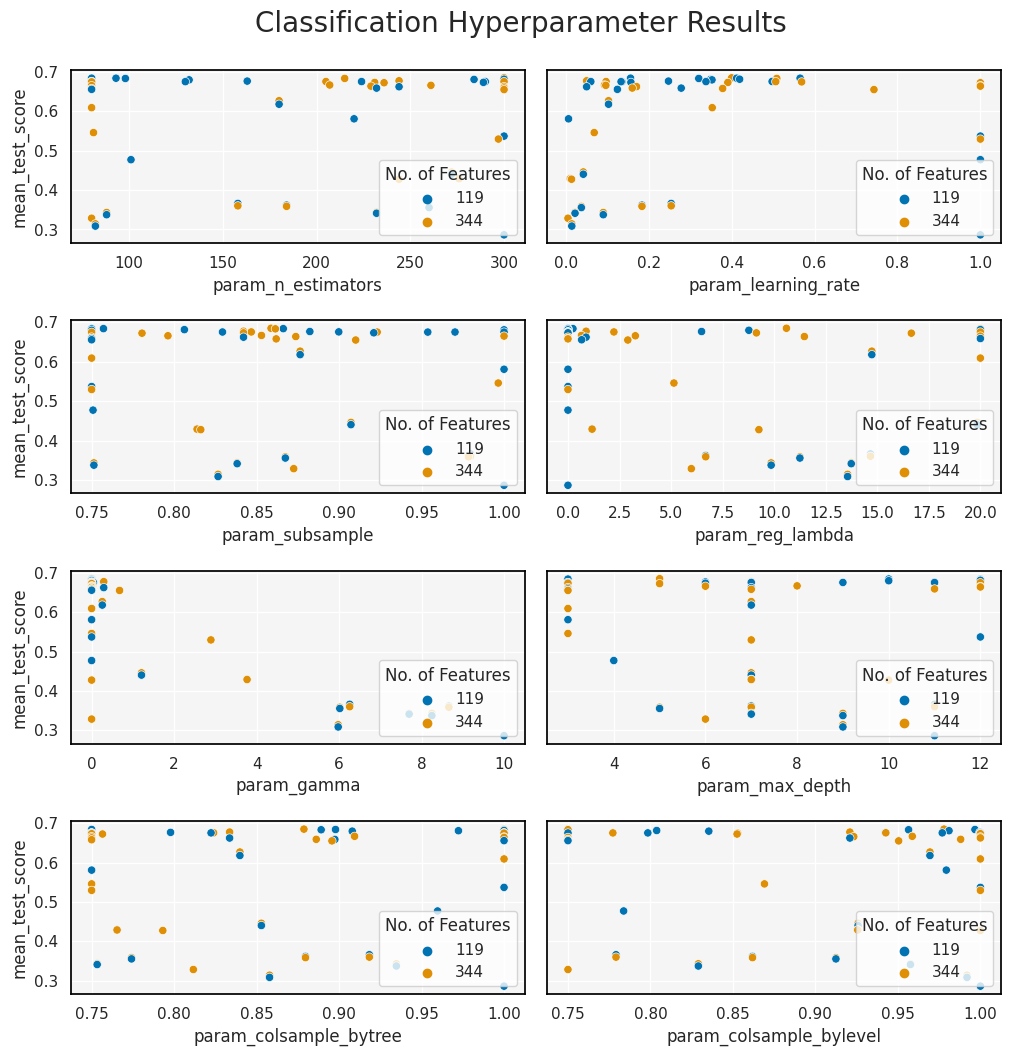

In [22]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space_categ, axs.ravel())):
    sns.scatterplot(
        data=results_df_categ,
        x="param_" + param_category,
        y="mean_test_score",
        hue="features_count",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white", loc="lower right").set_title("No. of Features")

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Classification Hyperparameter Results", y=0.93, fontsize=20);

### 3. Results (Metrics)

In [23]:
# Storing results of each model from k-fold cross-validation with the best hyperparameters

Y_pred_list, Y_valid_list = list(), list()

# Looping through each of the cross validation folds
for train_index, test_index in skf_index_categ:
    # Fitting a model with the best hyperparamters
    CATEG_best_model = XGBClassifier(
        objective="multi:softmax",
        num_class=len(set(Y_categ)),
        **BSCV_categ.best_params_,
        random_state=1
    )

    CATEG_best_model.fit(
        X_categ_resampled[selected_features_categ].iloc[train_index],
        Y_categ_resampled[train_index],
    )

    # Storing predictions of each cross-validation in a list to later be concatenated
    Y_pred_list.append(
        CATEG_best_model.predict(
            X_categ_resampled[selected_features_categ].iloc[test_index]
        )
    )
    Y_valid_list.append(Y_categ_resampled[test_index].copy())

# Concatenating the predictions from each of the 5 runs
Y_pred_categ = np.concatenate(Y_pred_list)
Y_valid_categ = np.concatenate(Y_valid_list)

In [24]:
# Generating and showing metrics from k-fold cross validation

accuracy = accuracy_score(Y_valid_categ, Y_pred_categ)
b_accuracy = balanced_accuracy_score(Y_valid_categ, Y_pred_categ)
report_categ = classification_report(
    le_categ.inverse_transform(Y_valid_categ), le_categ.inverse_transform(Y_pred_categ)
)

print(
    f"""
***Accuracy Score: {accuracy:.1%}***
***Balanced Accuracy: {b_accuracy:.1%}***

The results below represent the SUM of 5 trials:
{report_categ}
"""
)


***Accuracy Score: 82.8%***
***Balanced Accuracy: 66.6%***

The results below represent the SUM of 5 trials:
                                  precision    recall  f1-score   support

                75th Anniversary       1.00      0.12      0.22         8
        75th Anniversary Edition       1.00      1.00      1.00         5
                        Altitude       0.60      0.42      0.49       325
                            Base       0.92      0.84      0.88       159
                             FWD       0.88      0.92      0.90        49
                   High Altitude       0.38      0.17      0.24        86
                          Laredo       0.73      0.75      0.74       704
                        Laredo E       0.73      0.40      0.52        47
                         Limited       0.84      0.96      0.90      1912
                     Limited 4x4       1.00      1.00      1.00         5
        Limited 75th Anniversary       1.00      1.00      1.00         5
L

### 3. Final Model

In [25]:
# Fitting the final model using entire training dataset and the best hyperparameters
CATEG_final_model = XGBClassifier(**BSCV_categ.best_params_, random_state=1)
CATEG_final_model.fit(X_categ[selected_features_categ], Y_categ)

# Generating predictions
Y_pred_categ_final = CATEG_final_model.predict(df_x_test[selected_features_categ])
Y_pred_categ_final = le_categ.inverse_transform(Y_pred_categ_final)

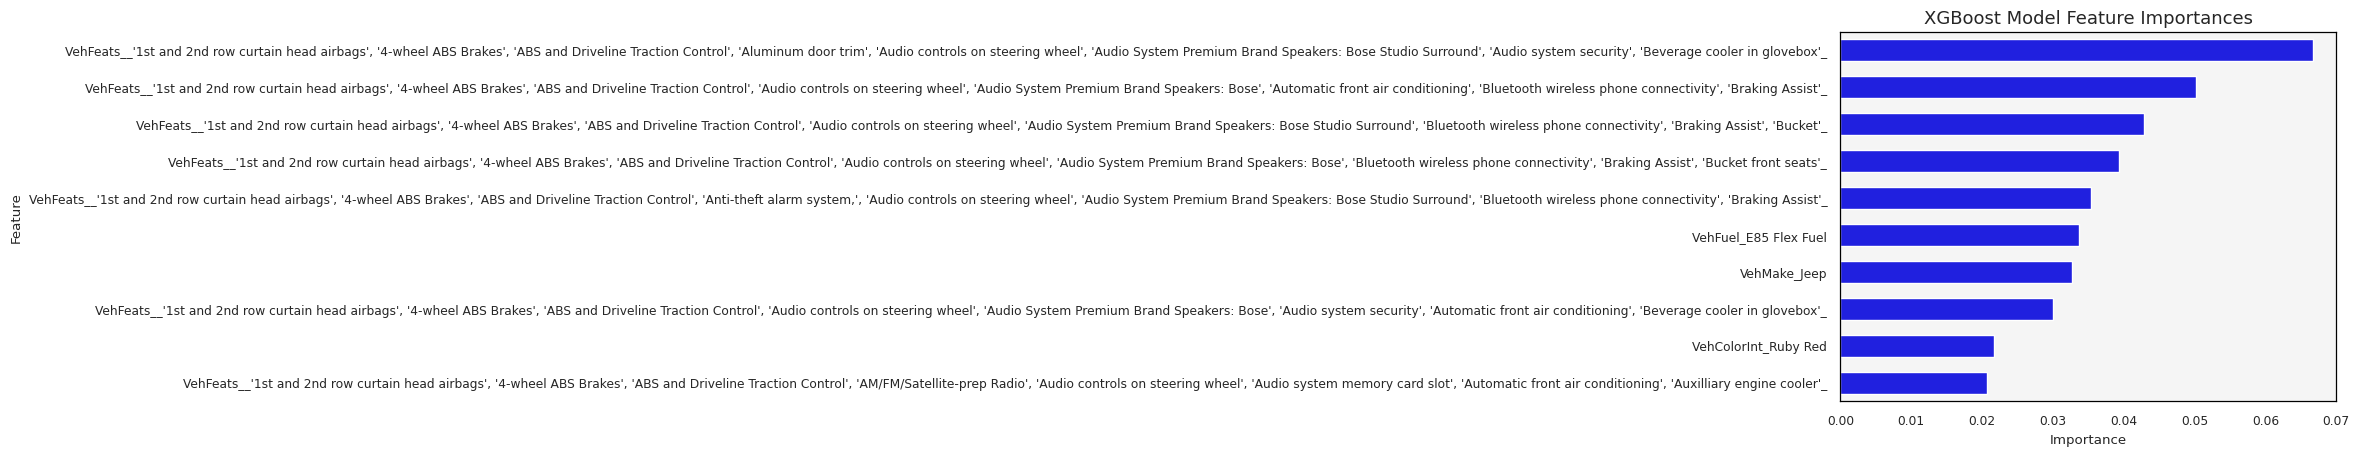

In [26]:
# Generating the final model feature importances

# Creating dataframe with features ranked by importance
feature_importance_df = (
    pd.DataFrame(
        {
            "Feature": X_categ[selected_features_categ].columns,
            "Importance": CATEG_final_model.feature_importances_,
        }
    )
    .sort_values("Importance", ascending=False)
    .reset_index()
)

# Plotting the top 10 features with their importance %
sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df[0:10],
    color="blue",
    width=0.6,
)
plt.title("XGBoost Model Feature Importances", fontsize=13);

# Section 4 - Regression Model (Listing Price)

### 4. Feature Selection

In [27]:
# Initializing model to use for feature selection
NUM_selector_model = XGBRegressor(
    learning_rate=0.1,
    random_state=1,
)

# Recursively removing the lowest performing feature(s)
selector_num = RFECV(
    NUM_selector_model,
    step=25,
    cv=iter(skf_index_num),
    scoring="neg_mean_squared_error",
)
selector_num = selector_num.fit(X_num, Y_num)

# Storing the cross-validation results
selectors_df_num = pd.DataFrame(selector_num.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# Storing the set of features resulting from the highest validation score
selected_features_num = X_num.columns[selector_num.support_]

display(selectors_df_num[0:3])
print(
    f"\n{sum(selector_num.support_)} out of {len(selector_num.support_)} features selected\n"
)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,-1.079930e+07,1.638157e+06,-1.062581e+07,-1.093277e+07,-8.124769e+06,-1.103133e+07,-1.328182e+07
10,-1.082775e+07,1.611133e+06,-1.053246e+07,-1.126383e+07,-8.178650e+06,-1.095545e+07,-1.320837e+07
11,-1.082775e+07,1.611133e+06,-1.053246e+07,-1.126383e+07,-8.178650e+06,-1.095545e+07,-1.320837e+07



194 out of 344 features selected



### 4. Hyperparamater Tuning

In [28]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_num = pd.DataFrame()

search_space_num = {
    "n_estimators": Integer(80, 300),
    "learning_rate": Real(0.005, 1.0, prior="log-uniform"),
    "subsample": Real(0.75, 1.0),
    "reg_lambda": Real(0.0, 20.0),
    "gamma": Real(0.0, 10.0),
    "max_depth": Integer(3, 12),
    "colsample_bytree": Real(0.75, 1.0),
    "colsample_bylevel": Real(0.75, 1.0),
}

for select_features in [X_num.columns, selected_features_num]:
    NUM_model = XGBRegressor(
        random_state=1,
    )

    BSCV_num = BayesSearchCV(
        NUM_model,
        search_space_num,
        n_iter=30,
        cv=iter(skf_index_num),
        scoring="neg_mean_squared_error",
        random_state=1,
    )
    BSCV_num.fit(X_num[select_features], Y_num)

    # Combining the results tables using different sets of features
    results_df_num = pd.concat(
        [
            results_df_num,
            pd.DataFrame(BSCV_num.cv_results_).assign(
                features_count=len(select_features)
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_num = results_df_num.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_num = results_df_num.iloc[0]["params"]

# Reverting to all features if performance is better
if results_df_num.iloc[0]["features_count"] == len(X_num.columns):
    selected_features_num = X_num.columns
    print(
        f"\nFeatures reverted back to all {len(selected_features_num)} out of {len(X_num.columns)}\n"
    )

display(results_df_num[0:3], best_params_num)

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,features_count
0,24,6.286142,1.294533,0.014070,0.000252,0.994932,0.75,10.0,0.079714,11,209,20.0,0.750184,"{'colsample_bylevel': 0.9949321424222104, 'col...",-8.052852e+06,-9.775217e+06,-7.093268e+06,-1.041723e+07,-1.212616e+07,-9.492945e+06,1.772011e+06,1,194
1,23,6.946524,0.856240,0.014361,0.000210,1.0,0.75,10.0,0.085354,12,202,20.0,0.861657,"{'colsample_bylevel': 1.0, 'colsample_bytree':...",-8.172223e+06,-9.488677e+06,-7.350236e+06,-1.072794e+07,-1.176379e+07,-9.500573e+06,1.613517e+06,2,194
2,26,6.207490,1.219874,0.014002,0.000360,1.0,0.75,10.0,0.085039,11,205,20.0,0.75,"{'colsample_bylevel': 1.0, 'colsample_bytree':...",-8.180242e+06,-1.005269e+07,-7.337343e+06,-1.020287e+07,-1.190421e+07,-9.535473e+06,1.611974e+06,3,194


OrderedDict([('colsample_bylevel', 0.9949321424222104),
             ('colsample_bytree', 0.75),
             ('gamma', 10.0),
             ('learning_rate', 0.07971377047333829),
             ('max_depth', 11),
             ('n_estimators', 209),
             ('reg_lambda', 20.0),
             ('subsample', 0.7501837821717487)])

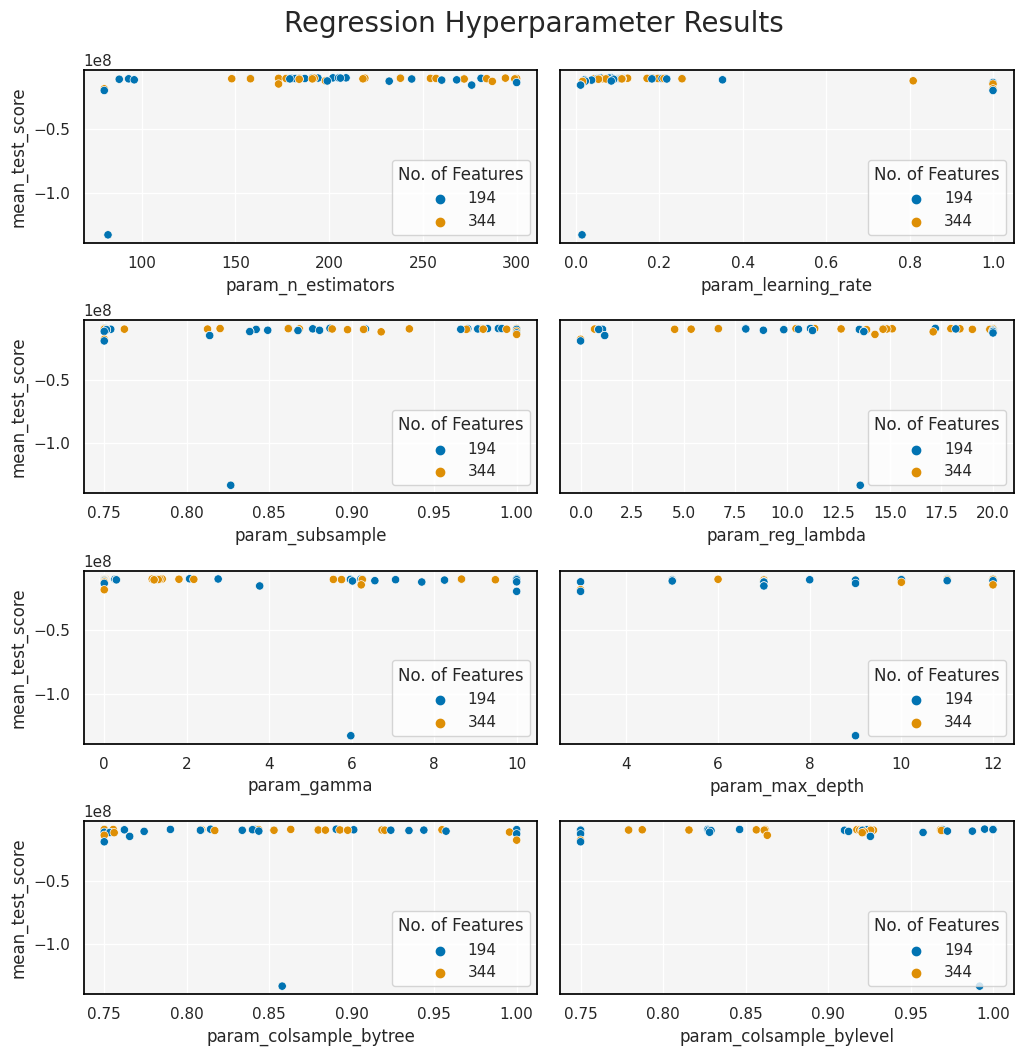

In [29]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space_num, axs.ravel())):
    sns.scatterplot(
        data=results_df_num,
        x="param_" + param_category,
        y="mean_test_score",
        hue="features_count",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white", loc="lower right").set_title("No. of Features")

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Regression Hyperparameter Results", y=0.93, fontsize=20);

### 4. Results (Metrics)

In [30]:
# Storing results of each model from k-fold cross-validation with the best hyperparameters

Y_pred_list, Y_valid_list = list(), list()

# Looping through each of the cross validation folds
for train_index, test_index in skf_index_num:
    # Fitting a model with the best hyperparamters
    NUM_best_model = XGBRegressor(**BSCV_num.best_params_, random_state=1)

    NUM_best_model.fit(
        X_num[selected_features_num].iloc[train_index], Y_num[train_index]
    )

    # Storing predictions of each cross-validation in a list to later be concatenated
    Y_pred_list.append(
        NUM_best_model.predict(X_num[selected_features_num].iloc[test_index])
    )
    Y_valid_list.append(Y_num[test_index].copy())

# Concatenating the predictions from each of the 5 runs
Y_pred_num = np.concatenate(Y_pred_list)
Y_valid_num = np.concatenate(Y_valid_list)

In [31]:
# Generating and showing metrics from k-fold cross validation

MSE = mean_squared_error(Y_valid_num, Y_pred_num)
RMSE = math.sqrt(MSE)

ListPrice_mean = Y_num.mean()
ListPirce_stdev = Y_num.std()

print(
    f"""
***Model RMSE: {RMSE:.2f}***
***Listing Price Standard Deviation: {Y_num.std():.2f}***
"""
)


***Model RMSE: 3081.02***
***Listing Price Standard Deviation: 7538.34***



### 4. Final Model

In [32]:
# Fitting the final model using entire training dataset and the best hyperparameters
NUM_final_model = XGBRegressor(**BSCV_num.best_params_, random_state=1)
NUM_final_model.fit(X_num[selected_features_num], Y_num)

# Generating predictions
Y_pred_num_final = NUM_final_model.predict(df_x_test[selected_features_num])

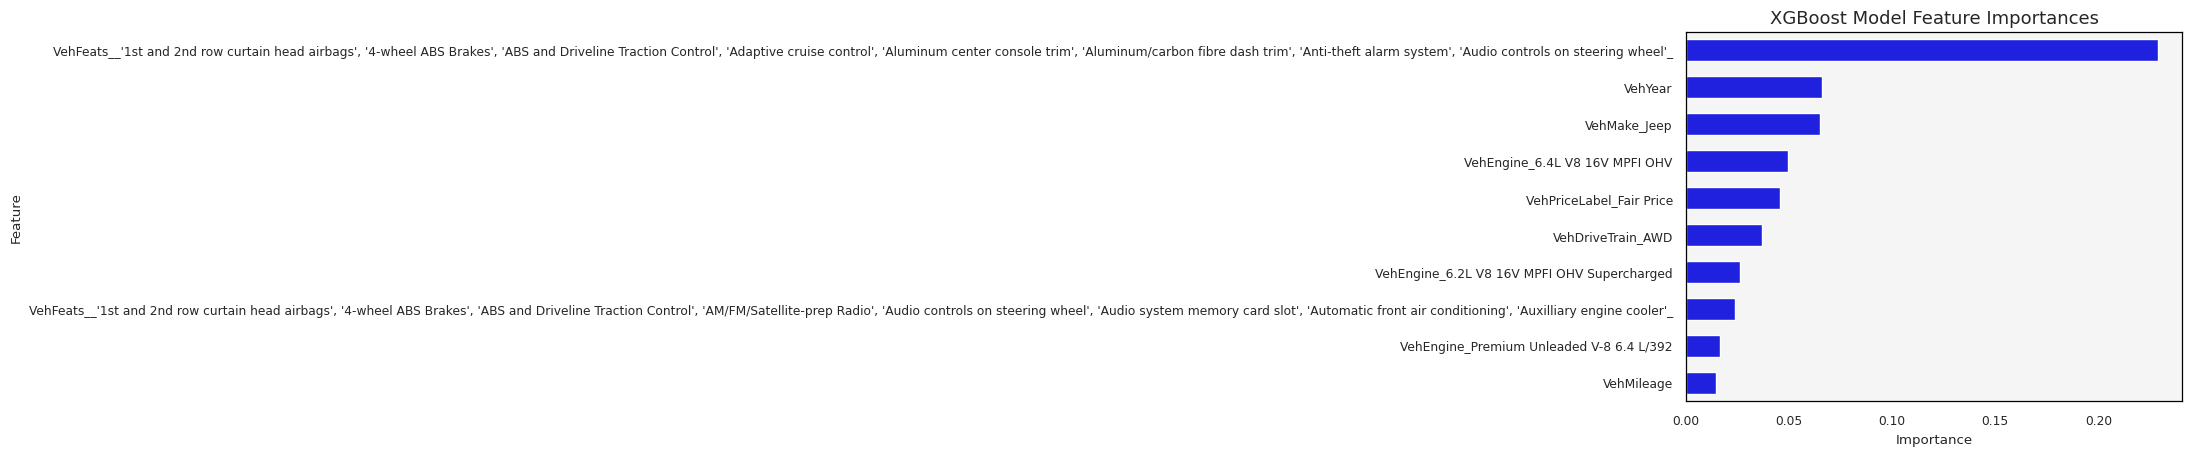

In [33]:
# Generating the final model feature importances

# Creating dataframe with features ranked by importance
feature_importance_df = (
    pd.DataFrame(
        {
            "Feature": X_num[selected_features_num].columns,
            "Importance": NUM_final_model.feature_importances_,
        }
    )
    .sort_values("Importance", ascending=False)
    .reset_index()
)

# Plotting the top 10 features with their importance %
sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df[0:10],
    color="blue",
    width=0.6,
)
plt.title("XGBoost Model Feature Importances", fontsize=13);

# 5. Predictions Output

In [34]:
# Combining predictions in the requested format
df_predictions_output = pd.concat(
    [
        df_test["ListingID"],
        pd.DataFrame(Y_pred_categ_final),
        pd.DataFrame(Y_pred_num_final),
    ],
    axis=1,
)

# Saving predictions to .csv file
df_predictions_output.to_csv("predictions_output_2.csv", header=False, index=False)